In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import ClassifierMixin
from sklearn.tree import DecisionTreeClassifier

sns.set_theme()

Matrix = pd.DataFrame | pd.Series | np.ndarray
Vector = Matrix

In [ ]:
def criterion_gini(y: np.ndarray) -> float:
    k = y.shape[0]
    counts = np.unique(y, return_counts=True)[1]
    counts = counts / k
    return counts @ (1 - counts)


gini_check = np.asarray([1, 1, 1, 1, 2, 2, 2, 3, 3, 4])
assert criterion_gini(gini_check) == 0.7


criterions = {
    "gini": criterion_gini,
}

In [ ]:
Predicate = tuple[int, float]


class Tree:
    class Node:
        value = None
        predicate: Predicate = None
        left: "Tree.Node" = None
        right: "Tree.Node" = None

    def __init__(self) -> None:
        self.depth = 0
        self.root = None

    def set_root(self, node: Node) -> None:
        self.root = node


Node = Tree.Node


class D3GreedyClassifier(ClassifierMixin):
    def __init__(
        self, *, max_depth: int | None = None, criterion: str = "gini"
    ) -> None:
        self.max_depth = max_depth
        self.criterion = criterions[criterion]

    def __calculate_ig(
        self, j: int, t: float, idx: np.ndarray
    ) -> tuple[np.ndarray, np.ndarray, float]:
        indices_left = self.X[idx, j] <= t
        indices_right = np.invert(indices_left)

        idx_left = idx[indices_left]
        idx_right = idx[indices_right]

        return (
            idx_left,
            idx_right,
            (
                self.criterion(self.y[idx])
                - idx_left.shape[0]
                * self.criterion(self.y[idx_left])
                / self.X[idx].shape[0]
                - idx_right.shape[0]
                * self.criterion(self.y[idx_right])
                / self.X[idx].shape[0]
            ),
        )

    def __find_predicate(
        self, idx: np.ndarray
    ) -> tuple[tuple[np.ndarray, np.ndarray], Predicate]:
        max_ig = -np.inf
        indices = None
        predicate = None
        for j in range(self.X.shape[1]):
            for t in self.X[idx, j]:
                idx_left, idx_right, ig = self.__calculate_ig(j, t, idx)

                if ig > max_ig:
                    max_ig = ig
                    indices = (idx_left, idx_right)
                    predicate = (j, t)

        return indices, predicate

    def __stop(self, idx: np.ndarray) -> bool:
        if self.get_depth() == self.max_depth:
            return True

        if np.unique(self.y[idx]).shape[0] == 1:
            return True

        if (self.X[idx] == self.X[idx][0]).all():
            return True

        return False

    def __calculate_value(self, idx: np.ndarray) -> int:
        cnt = np.unique(self.y[idx], return_counts=True)
        return cnt[0][np.argmax(cnt[1])]

    def fit(self, X: Matrix, y: Vector, **kwargs) -> "D3GreedyClassifier":
        self.X = np.asarray(X)
        self.y = np.asarray(y)

        self.__tree = Tree()

        v = Node()
        self.__tree.set_root(v)

        indices = [(v, np.indices((X.shape[0],))[0])]

        while indices:
            v, idx = indices.pop(0)

            if self.__stop(idx):
                value = self.__calculate_value(idx)
                v.value = value

            else:
                ind, predicate = self.__find_predicate(idx)
                if ind[0].shape[0] == 0 or ind[1].shape[0] == 0:
                    value = self.__calculate_value(idx)
                    v.value = value
                    continue

                v.predicate = predicate

                l, r = Node(), Node()
                v.left = l
                v.right = r

                indices.append((l, ind[0]))
                indices.append((r, ind[1]))

            self.__tree.depth += 1

        del self.X
        del self.y

        return self

    def get_depth(self) -> int:
        return self.__tree.depth

    def predict(self, X: Matrix):
        X = np.asarray(X)

        res = []
        for obj in X:
            node = self.__tree.root
            while node.value is None:
                p = node.predicate
                if obj[p[0]] <= p[1]:
                    node = node.left
                else:
                    node = node.right
            res.append(node.value)
        return res

In [ ]:
from sklearn.datasets import load_iris

data = load_iris(as_frame=True)
X_iris = data.data
X_iris_np = np.asarray(X_iris)
y_iris = data.target

X_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


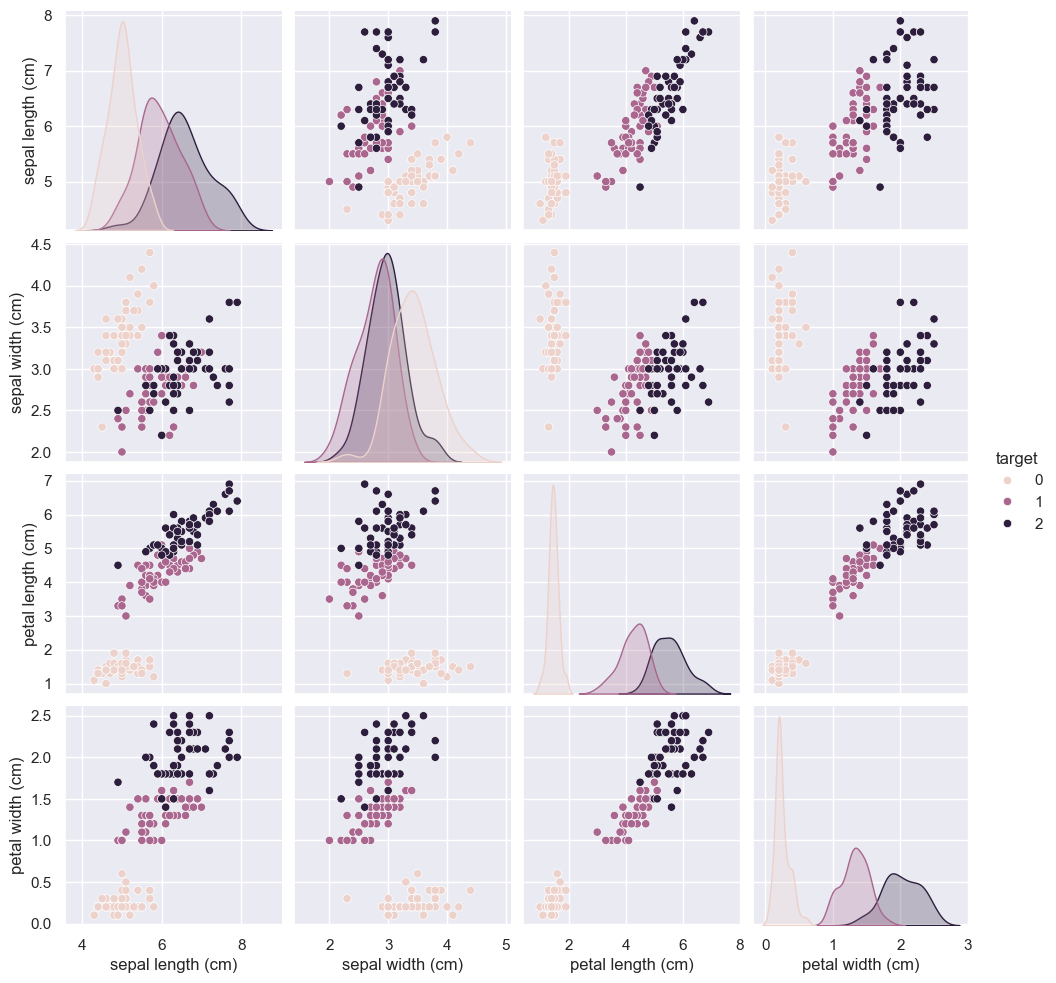

In [ ]:
sns.pairplot(pd.concat([X_iris, y_iris], axis=1), hue="target")

In [ ]:
tree_model = D3GreedyClassifier(max_depth=2)
tree_model.fit(X_iris, y_iris)
y_pred = tree_model.predict(X_iris_np)

In [ ]:
(y_pred == y_iris).all()

False

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42
)


tree_model = D3GreedyClassifier()
tree_model.fit(X_train, y_train)
# y_pred = tree_model.predict(X_test)

print("Train", f1_score(y_train, tree_model.predict(X_train), average="macro"))
print("Test", f1_score(y_test, tree_model.predict(X_test), average="macro"))

Train 1.0
Test 0.9484126984126983


In [ ]:
tree_model_govno = DecisionTreeClassifier(
    criterion="gini",
)

tree_model_govno.fit(X_train, y_train)
# y_pred = tree_model.predict(X_test)

print("Train", f1_score(y_train, tree_model_govno.predict(X_train), average="macro"))
print("Test", f1_score(y_test, tree_model_govno.predict(X_test), average="macro"))

Train 1.0
Test 1.0


In [ ]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
X = data[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]
X = pd.get_dummies(X, drop_first=True)
X["Age"] = X["Age"].fillna(X["Age"].median()).astype(int)
y = data["Survived"]

In [ ]:
X.isna().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [18]:
%%timeit 1000

tree_model = D3GreedyClassifier()
tree_model.fit(X_train, y_train)
# y_pred = tree_model.predict(X_test)

# print("Train", f1_score(y_train, tree_model.predict(X_train), average="macro"))
# print("Test", f1_score(y_test, tree_model.predict(X_test), average="macro"))


1.78 s ± 81.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit 1000
tree_model_normal = DecisionTreeClassifier(
    criterion="gini",
)

tree_model_normal.fit(X_train, y_train)
# y_pred = tree_model.predict(X_test)

# print("Train", f1_score(y_train, tree_model_normal.predict(X_train), average="macro"))
# print("Test", f1_score(y_test, tree_model_normal.predict(X_test), average="macro"))

1.13 ms ± 224 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
from sklearn.datasets import make_regression

X, y = make_regression()

In [ ]:
# y_pred = np.asarray([0.2, 0.1, 0.7])
y_pred = np.asarray([0.1, 0.1, 0.8])
y_true = np.asarray([0, 0, 1])

In [ ]:
def multiclass_log_loss(y_true, y_pred):
    """
    Расчет многоклассового log-loss.

    :param y_true: Истинные метки классов (в one-hot виде), размер (n_samples, n_classes)
    :param y_pred: Предсказанные вероятности для классов, размер (n_samples, n_classes)
    :return: Log-loss
    """
    # Убедимся, что предсказания не содержат вероятностей равных 0 или 1
    # epsilon = 1e-15
    # y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Расчет log-loss
    log_loss = -np.mean(np.sum(y_true * np.log(y_pred)))

    return log_loss

In [ ]:
multiclass_log_loss(y_true, y_pred)

np.float64(0.2231435513142097)

# PCA


In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_iris_scaled = pd.DataFrame(std_scaler.fit_transform(X_iris), columns=X_iris.columns)
X_iris_scaled.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


In [ ]:
cov_matrix = X_iris_scaled.cov()

In [ ]:
cov_matrix.T @ cov_matrix

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),2.475704,-0.920334,2.616213,2.552225
sepal width (cm),-0.920334,1.349363,-1.329571,-1.257660
petal length (cm),2.616213,-1.329571,2.909287,2.833288
petal width (cm),2.552225,-1.257660,2.833288,2.766955


In [ ]:
X_iris_scaled.T @ X_iris_scaled

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),150.000000,-17.635468,130.763066,122.691169
sepal width (cm),-17.635468,150.000000,-64.266016,-54.918890
petal length (cm),130.763066,-64.266016,150.000000,144.429815
petal width (cm),122.691169,-54.918890,144.429815,150.000000


In [ ]:
a, b = np.linalg.eig(cov_matrix)

In [ ]:
a, b = np.linalg.eig(X_iris_scaled.T @ X_iris_scaled)

In [ ]:
np.asarray([[3, 1, 1], [-1, 3, 1]]).shape

(2, 3)

In [ ]:
np.linalg.svd(np.asarray([[3, 1, 1], [-1, 3, 1]]))

SVDResult(U=array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]]), S=array([3.46410162, 3.16227766]), Vh=array([[-4.08248290e-01, -8.16496581e-01, -4.08248290e-01],
       [-8.94427191e-01,  4.47213595e-01,  5.84574207e-16],
       [-1.82574186e-01, -3.65148372e-01,  9.12870929e-01]]))

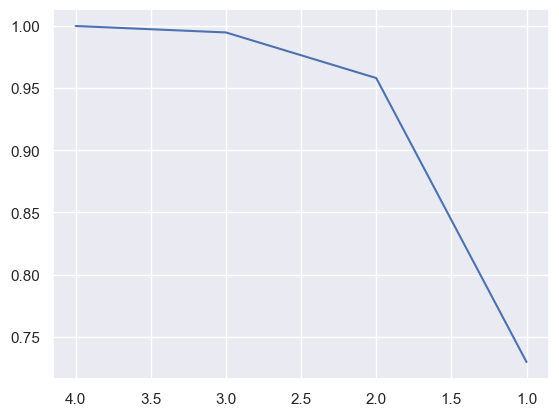

In [ ]:
x = range(4, 0, -1)
y = [a[:i].sum() / a.sum() for i in x]
_, ax = plt.subplots()
ax.plot(x, y)
ax.invert_xaxis()
plt.show()

In [ ]:
sns.pairplot(X_iris_scaled @ b[:3].T)

In [ ]:
# def euclidian_distance(x, y):
#     return np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))


# def euclidian_distance(x, y):
#     return np.sum((x - y) ** 2)

In [ ]:
X_iris.merge(X_iris, how="cross")

,sepal length (cm)_x,sepal width (cm)_x,petal length (cm)_x,petal width (cm)_x,sepal length (cm)_y,sepal width (cm)_y,petal length (cm)_y,petal width (cm)_y
0,5.1,3.5,1.4,0.2,5.1,3.5,1.4,0.2
1,5.1,3.5,1.4,0.2,4.9,3.0,1.4,0.2
2,5.1,3.5,1.4,0.2,4.7,3.2,1.3,0.2
3,5.1,3.5,1.4,0.2,4.6,3.1,1.5,0.2
4,5.1,3.5,1.4,0.2,5.0,3.6,1.4,0.2
...,...,...,...,...,...,...,...,...
22495,5.9,3.0,5.1,1.8,6.7,3.0,5.2,2.3
22496,5.9,3.0,5.1,1.8,6.3,2.5,5.0,1.9
22497,5.9,3.0,5.1,1.8,6.5,3.0,5.2,2.0
22498,5.9,3.0,5.1,1.8,6.2,3.4,5.4,2.3
